# Initial Imports

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.metrics import accuracy_score
from collections import defaultdict

ECG_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_ECG-only.csv").drop(columns = "ID")
EDA_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_EDA-only.csv").drop(columns = "ID")
EEG_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_EEG-only.csv").drop(columns = "ID")
EYE_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_EYE-only.csv").drop(columns = "ID").replace([np.inf, -np.inf], np.nan).interpolate()
fNIRS_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_fNIRS-only.csv").drop(columns = "ID")
RSP_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_RSP-only.csv").drop(columns = "ID")

# Pre-Processing

In [48]:
# Isolate the outcomes variables
outcomes_df = ECG_df.iloc[:, ECG_df.shape[1] - 4:]

# Create binary variables for high and low 
adj_SA_1_median = np.median(outcomes_df["adjSA1"])
adj_SA_2_median = np.median(outcomes_df["adjSA2"])
adj_SA_3_median = np.median(outcomes_df["adjSA3"])
adj_SA_tot_median = np.median(outcomes_df["adjSAtotal"])

# Will be high if adjusted SA level score is equal to or above median, low otherwise
outcomes_df["Lv_1_Hi"] = (outcomes_df["adjSA1"] >= adj_SA_1_median).astype(int)
outcomes_df["Lv_2_Hi"] = (outcomes_df["adjSA2"] >= adj_SA_2_median).astype(int)
outcomes_df["Lv_3_Hi"] = (outcomes_df["adjSA3"] >= adj_SA_3_median).astype(int)
outcomes_df["Tot_Hi"] = (outcomes_df["adjSAtotal"] >= adj_SA_tot_median).astype(int)

# Remove outcomes variables from each sensor dataframe
ECG_df = ECG_df.iloc[:, :ECG_df.shape[1] - 4]
EDA_df = EDA_df.iloc[:, :EDA_df.shape[1] - 4]
EEG_df = EEG_df.iloc[:, :EEG_df.shape[1] - 4]
EYE_df = EYE_df.iloc[:, :EYE_df.shape[1] - 4]
fNIRS_df = fNIRS_df.iloc[:, :fNIRS_df.shape[1] - 4]
RSP_df = RSP_df.iloc[:, :RSP_df.shape[1] - 4]

# Free Memory
del adj_SA_1_median
del adj_SA_2_median
del adj_SA_3_median
del adj_SA_tot_median

# Training Models

In [36]:
def get_test_scores(sensor_df, outcomes_df, outcome_var):
    test_scores = defaultdict(list)

    # for i in range(10):
    skf = StratifiedKFold(n_splits = 5, shuffle = True)
    for i, (CV_idx, test_idx) in enumerate(skf.split(sensor_df, outcomes_df[outcome_var])):
        # Train-Test Split for the Fold
        pred_CV = sensor_df.iloc[CV_idx, :]
        pred_test = sensor_df.iloc[test_idx, :]
        out_CV = outcomes_df.iloc[CV_idx, :]
        out_test = outcomes_df.iloc[test_idx, :]

        cv = StratifiedKFold(n_splits = 10, shuffle = True)

        # Initialize Models
        reg_model = LogisticRegression(
            penalty = None,
            fit_intercept = False, 
            n_jobs = -1, 
            max_iter = 10000,
            solver = "saga")

        Ridge_model = LogisticRegressionCV(
            Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
            cv = cv, 
            fit_intercept = False, 
            solver = "saga", 
            n_jobs = -1, 
            max_iter = 10000, 
            scoring = "accuracy", 
            refit = True)

        LASSO_model = LogisticRegressionCV(
            Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
            cv = cv, 
            fit_intercept = False, 
            penalty = "l1", 
            solver = "saga", 
            n_jobs = -1, 
            max_iter = 10000, 
            scoring = "accuracy", 
            refit = True)

        # RFE_model = RFECV(
        #     estimator = LogisticRegression(
        #         max_iter = 10000, 
        #         solver = "saga", 
        #         fit_intercept = False,
        #         n_jobs = - -1), 
        #     cv = cv, 
        #     scoring = "accuracy", 
        #     n_jobs = -1)

        # RFE_No_Penalty_model = RFECV(
        #     estimator = LogisticRegression(
        #         penalty = None, 
        #         max_iter = 10000, 
        #         solver = "saga", 
        #         fit_intercept = False), 
        #     cv = cv, 
        #     scoring = "accuracy", 
        #     n_jobs = -1)



        # Fit Models with CV Splits
        reg_model.fit(pred_CV, out_CV[outcome_var])
        Ridge_model.fit(pred_CV, out_CV[outcome_var])
        LASSO_model.fit(pred_CV, out_CV[outcome_var])
        # RFE_model.fit(pred_CV, out_CV[outcome_var])
        # print("RFE Model Finished Fitting")
        # RFE_No_Penalty_model.fit(pred_CV, out_CV[outcome_var])
        # print("RFE (No Penalty) Model Finished Fitting")



        # Append Best Model's Score
        test_scores["Regular"].append(reg_model.score(pred_test, out_test[outcome_var]))
        test_scores["Ridge"].append(Ridge_model.score(pred_test, out_test[outcome_var]))
        test_scores["LASSO"].append(LASSO_model.score(pred_test, out_test[outcome_var]))
        # test_scores["RFE"].append(RFE_model.score(pred_test, out_test[outcome_var]))
        # test_scores["RFE (No Penalty)"].append(RFE_No_Penalty_model.score(pred_test, out_test[outcome_var]))

    return test_scores

## SA 1

In [37]:
ECG_test_scores = get_test_scores(ECG_df, outcomes_df, "Lv_1_Hi")

# Print results
for key in ECG_test_scores:
    print(key, np.mean(ECG_test_scores[key]))

# Ridge 0.5527322404371585
# LASSO 0.6150273224043716
# RFE 0.5493989071038252
# RFE (No Penalty) 0.5625136612021857

# Regular 0.5638306010928962
# Ridge 0.5851693989071038
# LASSO 0.588120218579235

Regular 0.5922950819672131
Ridge 0.5923497267759562
LASSO 0.5825136612021857


In [38]:
EDA_test_scores = get_test_scores(EDA_df, outcomes_df, "Lv_1_Hi")

# Print results
for key in EDA_test_scores:
    print(key, np.mean(EDA_test_scores[key]))

# Ridge 0.5526775956284153
# LASSO 0.5166666666666667
# RFE 0.5529508196721311
# RFE (No Penalty) 0.5165573770491804

# Regular 0.5499945355191256
# Ridge 0.5303224043715846
# LASSO 0.5207431693989071

Regular 0.5463934426229508
Ridge 0.532896174863388
LASSO 0.5230054644808744


In [39]:
EEG_test_scores = get_test_scores(EEG_df, outcomes_df, "Lv_1_Hi")

# Print results
for key in EEG_test_scores:
    print(key, np.mean(EEG_test_scores[key]))

# Regular 0.5266284153005465
# Ridge 0.5259617486338798
# LASSO 0.5111857923497268

Regular 0.5132786885245901
Ridge 0.51
LASSO 0.5362295081967213


In [ ]:
EYE_test_scores = get_test_scores(EYE_df, outcomes_df, "Lv_1_Hi")

# Print results
for key in EYE_test_scores:
    print(key, np.mean(EYE_test_scores[key]))

# Regular 0.5754644808743169
# Ridge 0.5890163934426229
# LASSO 0.6152459016393442

Regular 0.5754644808743169
Ridge 0.5890163934426229
LASSO 0.6152459016393442


In [50]:
fNIRS_test_scores = get_test_scores(fNIRS_df, outcomes_df, "Lv_1_Hi")

# Print results
for key in fNIRS_test_scores:
    print(key, np.mean(fNIRS_test_scores[key]))

Regular 0.5687431693989071
Ridge 0.5687431693989071
LASSO 0.5885792349726776


In [51]:
RSP_test_scores = get_test_scores(RSP_df, outcomes_df, "Lv_1_Hi")

# Print results
for key in RSP_test_scores:
    print(key, np.mean(RSP_test_scores[key]))

/home/jshen/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jshen/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Regular 0.5133333333333333
Ridge 0.5066666666666666
LASSO 0.5032786885245901


## Graphing Test Scores

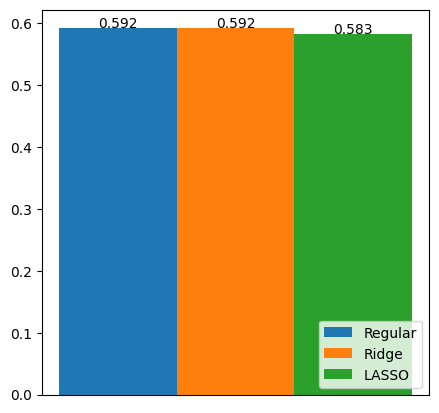

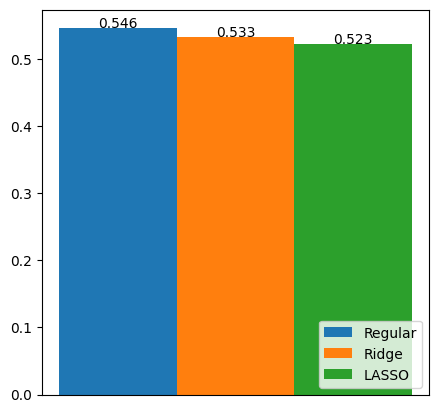

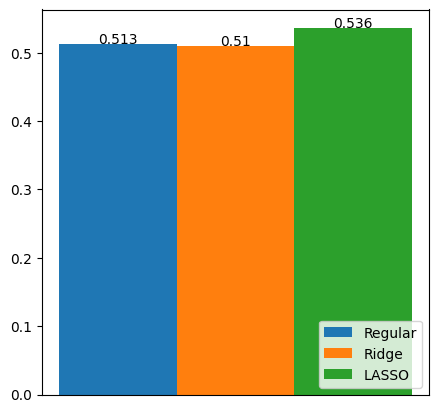

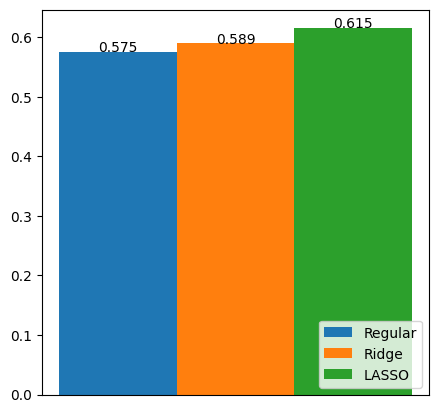

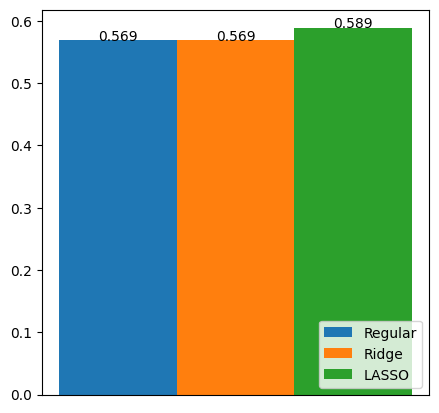

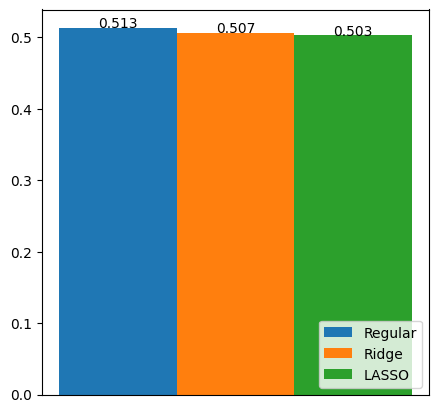

In [60]:
for test_scores in [ECG_test_scores, EDA_test_scores, EEG_test_scores, EYE_test_scores, fNIRS_test_scores, RSP_test_scores]:
    width = 0.3
    i = 0
    plt.figure(figsize = (5, 5))
    for key in test_scores:
        plt.bar(width * i, np.mean(test_scores[key]), width, label = key)
        plt.text(width * i, np.mean(test_scores[key]), round(np.mean(test_scores[key]), 3), ha = "center")
        i += 1

    plt.tick_params(
        axis = "x",          # changes apply to the x-axis
        which = "both",      # both major and minor ticks are affected
        bottom = False,      # ticks along the bottom edge are off
        top = False,         # ticks along the top edge are off
        labelbottom = False) # labels along the bottom edge are off

    plt.legend(loc = "lower right")
    plt.show();